In [193]:
import numpy as np
import pandas as pd
from volby.calc import Calc, Sim
from volby import utils
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats
import statsmodels.api as sm

In [194]:
seats = {"Praha": 24, "Stredocesky": 26, "Jihocesky": 13, "Plzensky": 11, "Karlovarsky": 5, "Ustecky": 13, "Liberecky": 8, "Kralovehradecky": 11, "Pardubicky": 10, "Vysocina": 10, "Jihomoravsky": 23, "Olomoucky": 12, "Zlinsky": 12, "Moravskoslezky": 22}

In [195]:
# get data from 2017 election
volby_2017 = pd.read_html("https://volby.cz/pls/ps2017/ps61?xjazyk=CZ&xv=1", attrs = {'class': 'table'}, index_col = 0, na_values = ["-"], thousands = "\xa0", encoding = "utf-8", decimal = ",")[0]
volby_2017 = volby_2017.apply(lambda x: x.astype(float), axis=1)
volby_2017 = volby_2017.iloc[np.arange(0,31), np.arange(1,volby_2017.shape[1])]
volby_2017.fillna(0, inplace = True)
volby2017 = volby_2017.to_dict()

In [196]:
#check the code is correct
v2017 = Calc(n_seats = seats, results = volby2017)
v2017.assign_seats(threshold = 0.05, inplace = False)

Praha  Stredocesky  Jihocesky  Plzensky  Karlovarsky  Ustecky  \
1 ODS           5            4          2         2            0        1   
4 ČSSD          1            2          1         1            0        1   
7 STAN          1            2          0         0            0        0   
8 KSČM          1            2          1         1            0        1   
15 Piráti       5            3          1         1            1        1   
20 TOP 09       3            2          1         0            0        0   
21 ANO          6            9          5         5            3        7   
24 KDU-ČSL      1            0          1         0            0        0   
29 SPD          1            2          1         1            1        2   

            Liberecky  Kralovehradecky  Pardubicky  Vysocina  Jihomoravsky  \
1 ODS               1                1           1         1             3   
4 ČSSD              0                1           1         1             2   
7 STAN              1                0           0         0             1   
8 KSČM              0                1           1         1             2   
15 Piráti           1                1           1         1             2   
20 TOP 09           0                0           0         0             1   
21 ANO              4                5           4         4             7   
24 KDU-ČSL          0                1           1         1             2   
29 SPD              1                1           1         1             3   

            Olomoucky  Zlinsky  Moravskoslezky  
1 ODS               1        1               2  
4 ČSSD              1        1               2  
7 STAN              0        1               0  
8 KSČM              1        1               2  
15 Piráti           1        1               2  
20 TOP 09           0        0               0  
21 ANO              5        4              10  
24 KDU-ČSL          1        1               1  
29 SPD              2        2               3

In [197]:
# simulate lection with 8 parties, 4 smaller, 3 medium and one stronger
sim_volby = Sim(n_seats = seats, n_parties=8, alpha = np.array([4,5,5,8,10,11,15,20]), threshold = 0.05)
sim_volby.sim_one()

print("Prc votes {}".format(sim_volby.votes.sum(axis = 1) / np.sum(sim_volby.votes.sum(axis = 1))))
print("Prc seats {}".format(sim_volby.seats.sum(axis = 1) / np.sum(sim_volby.seats.sum(axis = 1))))

Prc votes 0    0.047429
1    0.064508
2    0.067165
3    0.109679
4    0.118365
5    0.155294
6    0.167637
7    0.269923
dtype: float64
Prc seats 1    0.050
2    0.060
3    0.100
4    0.130
5    0.165
6    0.185
7    0.310
dtype: float64


In [198]:
# simulate elextion
sim_volby.sim_multi(N = 5000)

Parties benefit when % vote is higher than 0.12


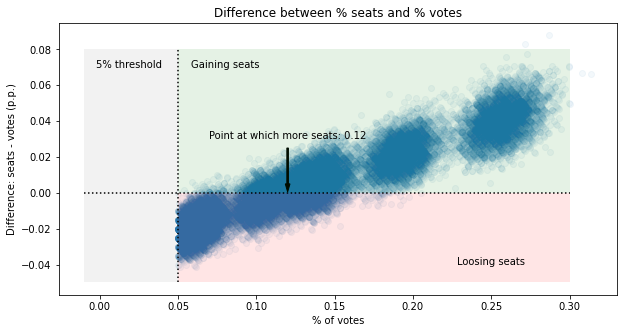

In [200]:
sim_diff = sim_volby.sim["seats"] - sim_volby.sim["votes"]

# calculate when (on average) parties benefit
y = sim_diff.flatten()
X = sim_volby.sim["votes"].flatten()
# select only cases which pass the threshold
y = y[X >= 0.05]
X = X[X >= 0.05]

#fit a model
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
a, b = results.params
y_plus = np.round(-1 * a/b, 2)
print("Parties benefit when % vote is higher than {}".format(y_plus))

#plot
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(X[:, 1], y, alpha = 0.05)
ax.arrow(y_plus, 0.025, dx = 0, dy = -0.02, color = "black")
ax.text(y_plus, 0.03, s = "Point at which more seats: {}".format(y_plus), horizontalalignment = "center")
ax.set_title("Difference between % seats and % votes")
ax.set_ylabel("Difference: seats - votes (p.p.)")
ax.set_xlabel("% of votes")
ax.plot(np.linspace(-0.01,0.3), np.linspace(0,0), color = "black", linestyle = ":")
ax.add_patch(Rectangle((-0.01, -0.05), 0.06, 0.13, facecolor = 'grey', alpha = 0.1))
ax.plot(np.linspace(0.05,0.05), np.linspace(-0.05,0.08), color = "black", linestyle = ":")
ax.add_patch(Rectangle((0.05, -0.05), 0.25, 0.05, facecolor = 'red', alpha = 0.1))
ax.add_patch(Rectangle((0.05, 0), 0.25, 0.08, facecolor = 'green', alpha = 0.1))
ax.text(0.019, 0.07, s = "5% threshold", horizontalalignment = "center")
ax.text(0.08, 0.07, s = "Gaining seats", horizontalalignment = "center")
ax.text(0.25, -0.04, s = "Loosing seats", horizontalalignment = "center")
plt.show()